# Постановка задачи


# Импорты

In [1]:
# Системные импорты и настройки
import os
import sys
import yaml
import warnings
import ipynbname
import logging.config
import cProfile, pstats

warnings.filterwarnings('ignore')

# for local development
RT_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/rt_libs/src"
BA_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/basic_application/src"
sys.path.append(RT_LIBS_PATH)
sys.path.append(BA_LIBS_PATH)

# read config
with open('config.yaml', "r") as stream:
    config = yaml.safe_load(stream)
    
# set logging config
log_config = config.get("log", None)
logging.config.dictConfig(log_config)

# set notebook alias
ALIAS = ipynbname.name()
print(ALIAS)

g12


In [2]:
# DS frameworks
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

%matplotlib notebook

In [3]:
# NN Frameworks
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D, AveragePooling1D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.models import load_model, clone_model

devices = tf.config.list_physical_devices()
print(devices)

2023-05-27 00:47:10.727615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [4]:
# RT packages
from rl import DQNAgent
from env import TradeEnv
from core import ConstructorGen2

from core.observation_builder.precompute import PrecomputeOrderbookDiffFeature

from data_point import DataPointFactory

from train_tools import Player, plot_and_go
from train_tools.train_plot import TrainPlot4
from train_tools.train_manager import TrainManager

# Конфиг

In [5]:
#### Кофигурация трейдера - зависит от параметров обучения, поэтому приведена здесь.
trader_config = {
    "update_period": 60,
    "pairs": ["BTC_USDT"]
}

dataset_config = {
    "period": 60
}

#Конфиг для предварительного обсчета датасета
orderbook_levels = [0.001, 0.0025, 0.005, 0.01]

step_factor = (1, 3, 12)
observation_len = 120

# Параметры точки наблюдения
observation_config = {
    "observation_len": observation_len,             # Количество точек наблюдения в сэмпле
    "offset": max(step_factor) * observation_len,   # Хвост исторических данных
    "future_points": 0,                             # Количество будущех точек для предсказания тренда (временное решение)
    "step_size": 1                                 # Шаг по датасет
 }

In [6]:
observation_config

{'observation_len': 120, 'offset': 1440, 'future_points': 0, 'step_size': 1}

# Dataset

<IPython.core.display.Javascript object>


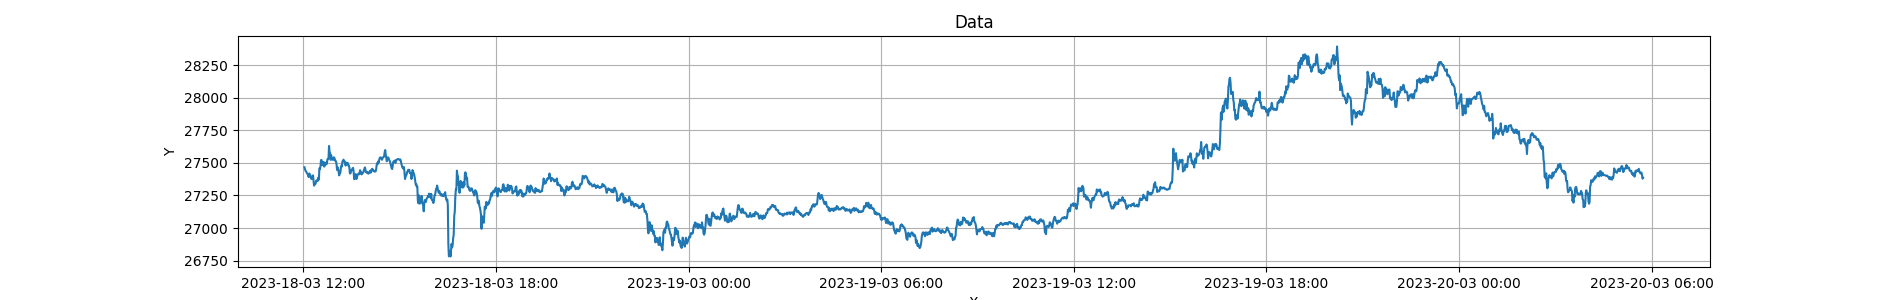

(2500, 11)


In [7]:
path = "/Users/alex/Dev_projects/RT/model_train/datasets/rt5/11.BTC_USDT-60.csv"
#path = "/Users/alex/Dev_projects/RT/model_train/datasets/rt5/03.BTC_USDT-300-train.csv"

data_1 = pd.read_csv(path, index_col='ts')

data_1 = data_1.iloc[0:2500, :]  # fast test
#data_1 = data_1.iloc[650:1450, :]  # fast train
plot_and_go(data_1, title="Data", fig_x=19, fig_y=3, dpi=50)

precompute = PrecomputeOrderbookDiffFeature()
for level in orderbook_levels:
    data_1 = precompute.process(data_1, level)

<IPython.core.display.Javascript object>


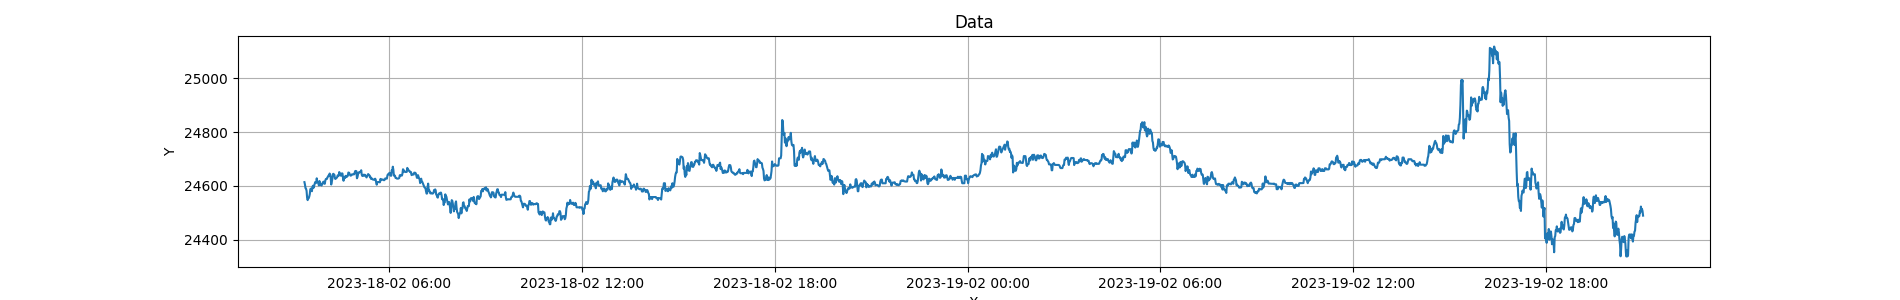

(2500, 11)


In [8]:
path = "/Users/alex/Dev_projects/RT/model_train/datasets/rt5/07.BTC_USDT-60.csv"
#path = "/Users/alex/Dev_projects/RT/model_train/datasets/rt5/03.BTC_USDT-300-test.csv"

data_2 = pd.read_csv(path, index_col='ts')
data_2 = data_2.iloc[200:2700, :] # fast test
#data_2 = data_2.iloc[300:650, :] # fast check
plot_and_go(data_2, title="Data", fig_x=19, fig_y=3, dpi=50)

precompute = PrecomputeOrderbookDiffFeature()
for level in orderbook_levels:
    data_2 = precompute.process(data_2, level)

# Инициализация компонентов

## Datapoint factory

In [9]:
dpf_train = DataPointFactory(dataset=data_1, **observation_config, alias='train')
dpf_test = DataPointFactory(dataset=data_2, **observation_config, alias='test')

## Env

In [10]:
core_config = {
    "context":{"class": "Context", "params":{}},
    "action_controller":{
        "class": "ActionControllerDiffReward3A",
        "params":{ 
            "penalty": -2, 
            "reward": 0,
            "market_fee": 0.0015,
            "scale_wait": 0, 
            "scale_open": 0, 
            #"scale_hold": 0, 
            "scale_close": 100, 
            "num_mean_obs": 2
        },
    },
    "observation_builder":{
        "class": "ObservationBuilderInput",
        "inputs": [
            {"class": "Input1D", "features": [{"class": "TradeStateFeature", "params": {}}]},
            {"class": "Input2D", "features": [
                {"class": "RatesFeature2D", "params": {"step_factor":1}},
                {"class": "RatesFeature2D", "params": {"step_factor":3}},
                {"class": "RatesFeature2D", "params": {"step_factor":12}},

                {"class": "ProfitFeature2D", "params": {"step_factor":1}},
                #{"class": "ProfitFeature2D", "params": {"step_factor":3}},
                
                {"class": "OrderbookDiffFeature2D", "params": {"step_factor":1, "level": 0.001}}, 
                {"class": "OrderbookDiffFeature2D", "params": {"step_factor":1, "level": 0.0025}}, 
                {"class": "OrderbookDiffFeature2D", "params": {"step_factor":1, "level": 0.005}},
                {"class": "OrderbookDiffFeature2D", "params": {"step_factor":1, "level": 0.01}}
            ]}
    ]
    }
}
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
core_constructor = ConstructorGen2()
env_core = core_constructor.get_core(core_config)

# train environment
env = TradeEnv(env_core, dpf_train, alias=ALIAS, log=False, log_obs=False)

AttributeError: module 'core.action_controller' has no attribute 'ActionControllerDiffReward3A'

## Нейронная сеть

In [ ]:

RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)

ACTIVATION = 'elu'
def create_q_model(env):
    num_actions = env.action_space
    #----------------------------------------------

    inp_static = Input(shape=env.observation_space[0])

    inp_timesteps = Input(shape=env.observation_space[1])
    conv_ts = Conv1D(filters=64, kernel_size=7, strides=1, padding="same", input_shape=env.observation_space[1], activation=ACTIVATION)(inp_timesteps)
    conv_ts = MaxPool1D(pool_size=2)(conv_ts)
    conv_ts = Conv1D(filters=128, kernel_size=5, strides=1, padding="same", activation=ACTIVATION)(conv_ts)    
    conv_ts = MaxPool1D(pool_size=2)(conv_ts)
    flt_ts = Flatten()(conv_ts)

    classif = Concatenate()([inp_static, flt_ts])

    classif = Dense(1024, activation=ACTIVATION)(classif)
    classif = Dense(1024, activation=ACTIVATION)(classif)

    #classif = Dropout(0.3)(classif)

    output = Dense(num_actions, activation='softmax')(classif)

    model = Model(inputs=[inp_static, inp_timesteps], outputs=output)
    return model
model = create_q_model(env)
model_target = create_q_model(env)

print(model.summary())

# Обучение

In [25]:
core_train = core_constructor.get_core(core_config)
core_test = core_constructor.get_core(core_config)
env = TradeEnv(core_train, dpf_train, alias=ALIAS, log=False, log_obs=False)

model = create_q_model(env)
model_target = create_q_model(env)

agent = DQNAgent(env, model, model_target)

agent.epsilon_greedy_frames = 100000
agent.epsilon_random_frames = int(0.05 * agent.epsilon_greedy_frames)
agent.max_memory_length = int(1.0 * agent.epsilon_greedy_frames)

agent.max_steps_per_episode = 50000

agent.gamma = 0.99
agent.epsilon_min = 0.01
agent.batch_size = 32
agent.update_after_actions = 4
agent.update_target_network = 1000
agent.loss_function = tf.keras.losses.Huber() #tf.keras.losses.MeanSquaredError()

learning_rate = 0.0001
agent.optimizer = Adam(learning_rate=learning_rate)    #Adam(learning_rate=learning_rate) RMSprop(learning_rate=learning_rate) SGD(learning_rate=learning_rate)


tp = TrainPlot4()
tm = TrainManager(agent, core_test, dpf_test, tp, alias=ALIAS)

In [27]:
tm.load_snapshot('1500000')

Снепшот не найден или поврежден. Что-то прошло не так


In [14]:
tp.init_plot(width=1000, height=800)
tp.update_plot(tm.history)

FigureWidget({
    'data': [{'legendgroup': '1',
              'line': {'color': '#109618', 'width': 1},
              'mode': 'lines',
              'name': 'Train',
              'type': 'scatter',
              'uid': '288c0540-55e5-482a-b3f3-6eef17aa4a7b',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'legendgroup': '1',
              'line': {'color': '#FF9900', 'width': 1},
              'mode': 'lines',
              'name': 'Test',
              'type': 'scatter',
              'uid': 'b12814a1-585a-4724-b0c5-dcd9a08305ab',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'legendgroup': '2',
              'line': {'color': '#D62728', 'width': 1},
              'mode': 'lines',
              'name': 'Train',
              'type': 'scatter',
              'uid': 'e243519b-e000-4a96-9fed-0463454f3600',
              'xaxis': 'x2',
              'yaxis': 'y3'},
             {'legendgroup': '2',
              'line': {'color': '#FF9900'

In [15]:
tm.go(max_frames=5000000, test_every=25000, snapshot_every=500000, update_plot_every=2500, save_since=0.06)

23:42:58 Running reward: 0.00     at episode 1    | frame 1000   | eps: 0.99 | Running loss: 0.00000
23:43:32 Running reward: -738.92  at episode 2    | frame 2000   | eps: 0.98 | Running loss: 0.40016
23:44:07 Running reward: -745.60  at episode 3    | frame 3000   | eps: 0.97 | Running loss: 0.34923
23:44:41 Running reward: -753.82  at episode 4    | frame 4000   | eps: 0.96 | Running loss: 0.32217
23:45:15 Running reward: -738.06  at episode 5    | frame 5000   | eps: 0.95 | Running loss: 0.30878
23:45:50 Running reward: -744.76  at episode 6    | frame 6000   | eps: 0.94 | Running loss: 0.30579
23:46:25 Running reward: -734.87  at episode 7    | frame 7000   | eps: 0.93 | Running loss: 0.30356
23:47:00 Running reward: -724.71  at episode 8    | frame 8000   | eps: 0.92 | Running loss: 0.30238
23:47:35 Running reward: -714.40  at episode 9    | frame 9000   | eps: 0.91 | Running loss: 0.30078
23:48:10 Running reward: -712.77  at episode 10   | frame 10000  | eps: 0.90 | Running loss

00:34:03 Running reward: -265.47  at episode 79   | frame 83000  | eps: 0.18 | Running loss: 0.20015
00:34:42 Running reward: -257.25  at episode 80   | frame 84000  | eps: 0.17 | Running loss: 0.19821
00:35:21 Running reward: -247.90  at episode 81   | frame 85000  | eps: 0.16 | Running loss: 0.19644
00:36:00 Running reward: -239.78  at episode 82   | frame 86000  | eps: 0.15 | Running loss: 0.19456
00:36:39 Running reward: -233.05  at episode 83   | frame 87000  | eps: 0.14 | Running loss: 0.19308
00:37:17 Running reward: -226.26  at episode 84   | frame 88000  | eps: 0.13 | Running loss: 0.19134
00:37:56 Running reward: -217.70  at episode 85   | frame 89000  | eps: 0.12 | Running loss: 0.18938
00:38:35 Running reward: -217.70  at episode 85   | frame 90000  | eps: 0.11 | Running loss: 0.18938
00:39:15 Running reward: -209.10  at episode 86   | frame 91000  | eps: 0.10 | Running loss: 0.18734
00:39:54 Running reward: -200.30  at episode 87   | frame 92000  | eps: 0.09 | Running loss

01:28:16 Running reward: -10.14   at episode 156  | frame 165000 | eps: 0.01 | Running loss: 0.04495
01:28:56 Running reward: -10.26   at episode 157  | frame 166000 | eps: 0.01 | Running loss: 0.04329
01:29:37 Running reward: -10.48   at episode 158  | frame 167000 | eps: 0.01 | Running loss: 0.04179
01:30:17 Running reward: -10.39   at episode 159  | frame 168000 | eps: 0.01 | Running loss: 0.04016
01:30:58 Running reward: -10.56   at episode 160  | frame 169000 | eps: 0.01 | Running loss: 0.03883
01:31:39 Running reward: -10.73   at episode 161  | frame 170000 | eps: 0.01 | Running loss: 0.03747
01:32:19 Running reward: -10.47   at episode 162  | frame 171000 | eps: 0.01 | Running loss: 0.03605
01:32:59 Running reward: -10.60   at episode 163  | frame 172000 | eps: 0.01 | Running loss: 0.03473
01:33:38 Running reward: -11.00   at episode 164  | frame 173000 | eps: 0.01 | Running loss: 0.03344
01:34:17 Running reward: -10.97   at episode 165  | frame 174000 | eps: 0.01 | Running loss

02:22:46 Running reward: -14.43   at episode 234  | frame 247000 | eps: 0.01 | Running loss: 0.00586
02:23:25 Running reward: -14.60   at episode 235  | frame 248000 | eps: 0.01 | Running loss: 0.00586
02:24:04 Running reward: -14.37   at episode 236  | frame 249000 | eps: 0.01 | Running loss: 0.00588
02:24:44 Running reward: -14.38   at episode 237  | frame 250000 | eps: 0.01 | Running loss: 0.00589
02:25:31 Running reward: -14.83   at episode 238  | frame 251000 | eps: 0.01 | Running loss: 0.00588
02:26:10 Running reward: -14.83   at episode 238  | frame 252000 | eps: 0.01 | Running loss: 0.00588
02:26:49 Running reward: -15.25   at episode 239  | frame 253000 | eps: 0.01 | Running loss: 0.00590
02:27:29 Running reward: -15.26   at episode 240  | frame 254000 | eps: 0.01 | Running loss: 0.00595
02:28:08 Running reward: -15.62   at episode 241  | frame 255000 | eps: 0.01 | Running loss: 0.00597
02:28:47 Running reward: -15.93   at episode 242  | frame 256000 | eps: 0.01 | Running loss

03:17:26 Running reward: -17.62   at episode 311  | frame 329000 | eps: 0.01 | Running loss: 0.00903
03:18:05 Running reward: -17.30   at episode 312  | frame 330000 | eps: 0.01 | Running loss: 0.00905
03:18:44 Running reward: -16.95   at episode 313  | frame 331000 | eps: 0.01 | Running loss: 0.00916
03:19:23 Running reward: -16.73   at episode 314  | frame 332000 | eps: 0.01 | Running loss: 0.00913
03:20:02 Running reward: -16.69   at episode 315  | frame 333000 | eps: 0.01 | Running loss: 0.00917
03:20:42 Running reward: -16.66   at episode 316  | frame 334000 | eps: 0.01 | Running loss: 0.00922
03:21:21 Running reward: -16.79   at episode 317  | frame 335000 | eps: 0.01 | Running loss: 0.00926
03:22:01 Running reward: -16.98   at episode 318  | frame 336000 | eps: 0.01 | Running loss: 0.00931
03:22:40 Running reward: -16.92   at episode 319  | frame 337000 | eps: 0.01 | Running loss: 0.00930
03:23:20 Running reward: -17.15   at episode 320  | frame 338000 | eps: 0.01 | Running loss

04:11:55 Running reward: -11.12   at episode 389  | frame 411000 | eps: 0.01 | Running loss: 0.00753
04:12:34 Running reward: -11.33   at episode 390  | frame 412000 | eps: 0.01 | Running loss: 0.00751
04:13:13 Running reward: -11.33   at episode 390  | frame 413000 | eps: 0.01 | Running loss: 0.00751
04:13:52 Running reward: -11.39   at episode 391  | frame 414000 | eps: 0.01 | Running loss: 0.00745
04:14:32 Running reward: -11.35   at episode 392  | frame 415000 | eps: 0.01 | Running loss: 0.00753
04:15:11 Running reward: -11.69   at episode 393  | frame 416000 | eps: 0.01 | Running loss: 0.00751
04:15:51 Running reward: -11.64   at episode 394  | frame 417000 | eps: 0.01 | Running loss: 0.00750
04:16:30 Running reward: -12.04   at episode 395  | frame 418000 | eps: 0.01 | Running loss: 0.00749
04:17:10 Running reward: -13.71   at episode 396  | frame 419000 | eps: 0.01 | Running loss: 0.00754
04:17:50 Running reward: -14.77   at episode 397  | frame 420000 | eps: 0.01 | Running loss

05:06:22 Running reward: -11.13   at episode 466  | frame 493000 | eps: 0.01 | Running loss: 0.00749
05:07:02 Running reward: -10.92   at episode 467  | frame 494000 | eps: 0.01 | Running loss: 0.00754
05:07:43 Running reward: -11.14   at episode 468  | frame 495000 | eps: 0.01 | Running loss: 0.00747
05:08:23 Running reward: -11.00   at episode 469  | frame 496000 | eps: 0.01 | Running loss: 0.00754
05:09:04 Running reward: -10.76   at episode 470  | frame 497000 | eps: 0.01 | Running loss: 0.00757
05:09:45 Running reward: -10.54   at episode 471  | frame 498000 | eps: 0.01 | Running loss: 0.00756
05:10:25 Running reward: -10.81   at episode 472  | frame 499000 | eps: 0.01 | Running loss: 0.00762
05:11:05 Running reward: -10.79   at episode 473  | frame 500000 | eps: 0.01 | Running loss: 0.00763
05:11:56 Running reward: -11.07   at episode 474  | frame 501000 | eps: 0.01 | Running loss: 0.00769
05:12:36 Running reward: -11.31   at episode 475  | frame 502000 | eps: 0.01 | Running loss

06:00:55 Running reward: -18.33   at episode 543  | frame 575000 | eps: 0.01 | Running loss: 0.00827
06:01:42 Running reward: -18.30   at episode 544  | frame 576000 | eps: 0.01 | Running loss: 0.00828
06:02:21 Running reward: -18.16   at episode 545  | frame 577000 | eps: 0.01 | Running loss: 0.00827
06:03:01 Running reward: -18.08   at episode 546  | frame 578000 | eps: 0.01 | Running loss: 0.00830
06:03:40 Running reward: -18.06   at episode 547  | frame 579000 | eps: 0.01 | Running loss: 0.00830
06:04:20 Running reward: -18.13   at episode 548  | frame 580000 | eps: 0.01 | Running loss: 0.00839
06:05:00 Running reward: -18.32   at episode 549  | frame 581000 | eps: 0.01 | Running loss: 0.00833
06:05:39 Running reward: -17.95   at episode 550  | frame 582000 | eps: 0.01 | Running loss: 0.00826
06:06:19 Running reward: -18.07   at episode 551  | frame 583000 | eps: 0.01 | Running loss: 0.00832
06:06:58 Running reward: -18.13   at episode 552  | frame 584000 | eps: 0.01 | Running loss

06:55:37 Running reward: -14.33   at episode 621  | frame 657000 | eps: 0.01 | Running loss: 0.00803
06:56:17 Running reward: -14.41   at episode 622  | frame 658000 | eps: 0.01 | Running loss: 0.00801
06:56:56 Running reward: -14.64   at episode 623  | frame 659000 | eps: 0.01 | Running loss: 0.00799
06:57:36 Running reward: -14.45   at episode 624  | frame 660000 | eps: 0.01 | Running loss: 0.00793
06:58:15 Running reward: -14.69   at episode 625  | frame 661000 | eps: 0.01 | Running loss: 0.00784
06:58:55 Running reward: -14.59   at episode 626  | frame 662000 | eps: 0.01 | Running loss: 0.00777
06:59:35 Running reward: -14.43   at episode 627  | frame 663000 | eps: 0.01 | Running loss: 0.00787
07:00:15 Running reward: -14.08   at episode 628  | frame 664000 | eps: 0.01 | Running loss: 0.00793
07:00:54 Running reward: -14.08   at episode 628  | frame 665000 | eps: 0.01 | Running loss: 0.00793
07:01:35 Running reward: -14.13   at episode 629  | frame 666000 | eps: 0.01 | Running loss

07:50:39 Running reward: -10.60   at episode 698  | frame 739000 | eps: 0.01 | Running loss: 0.00796
07:51:19 Running reward: -10.37   at episode 699  | frame 740000 | eps: 0.01 | Running loss: 0.00807
07:51:58 Running reward: -9.90    at episode 700  | frame 741000 | eps: 0.01 | Running loss: 0.00807
07:52:37 Running reward: -10.08   at episode 701  | frame 742000 | eps: 0.01 | Running loss: 0.00808
07:53:17 Running reward: -9.96    at episode 702  | frame 743000 | eps: 0.01 | Running loss: 0.00813
07:53:56 Running reward: -9.98    at episode 703  | frame 744000 | eps: 0.01 | Running loss: 0.00816
07:54:36 Running reward: -9.84    at episode 704  | frame 745000 | eps: 0.01 | Running loss: 0.00807
07:55:15 Running reward: -9.98    at episode 705  | frame 746000 | eps: 0.01 | Running loss: 0.00806
07:55:54 Running reward: -10.10   at episode 706  | frame 747000 | eps: 0.01 | Running loss: 0.00803
07:56:34 Running reward: -10.24   at episode 707  | frame 748000 | eps: 0.01 | Running loss

08:45:46 Running reward: -14.43   at episode 776  | frame 821000 | eps: 0.01 | Running loss: 0.00754
08:46:27 Running reward: -14.92   at episode 777  | frame 822000 | eps: 0.01 | Running loss: 0.00759
08:47:08 Running reward: -14.44   at episode 778  | frame 823000 | eps: 0.01 | Running loss: 0.00761
08:47:48 Running reward: -14.80   at episode 779  | frame 824000 | eps: 0.01 | Running loss: 0.00767
08:48:29 Running reward: -14.87   at episode 780  | frame 825000 | eps: 0.01 | Running loss: 0.00768
08:49:18 Running reward: -14.87   at episode 780  | frame 826000 | eps: 0.01 | Running loss: 0.00768
08:49:59 Running reward: -15.24   at episode 781  | frame 827000 | eps: 0.01 | Running loss: 0.00770
08:50:40 Running reward: -15.07   at episode 782  | frame 828000 | eps: 0.01 | Running loss: 0.00768
08:51:21 Running reward: -14.65   at episode 783  | frame 829000 | eps: 0.01 | Running loss: 0.00771
08:52:02 Running reward: -14.32   at episode 784  | frame 830000 | eps: 0.01 | Running loss

09:41:35 Running reward: -17.11   at episode 853  | frame 903000 | eps: 0.01 | Running loss: 0.00748
09:42:15 Running reward: -17.23   at episode 854  | frame 904000 | eps: 0.01 | Running loss: 0.00745
09:42:54 Running reward: -17.66   at episode 855  | frame 905000 | eps: 0.01 | Running loss: 0.00747
09:43:33 Running reward: -17.95   at episode 856  | frame 906000 | eps: 0.01 | Running loss: 0.00751
09:44:13 Running reward: -18.08   at episode 857  | frame 907000 | eps: 0.01 | Running loss: 0.00754
09:44:53 Running reward: -17.91   at episode 858  | frame 908000 | eps: 0.01 | Running loss: 0.00761
09:45:33 Running reward: -17.46   at episode 859  | frame 909000 | eps: 0.01 | Running loss: 0.00765
09:46:14 Running reward: -17.35   at episode 860  | frame 910000 | eps: 0.01 | Running loss: 0.00759
09:46:54 Running reward: -17.34   at episode 861  | frame 911000 | eps: 0.01 | Running loss: 0.00759
09:47:33 Running reward: -17.47   at episode 862  | frame 912000 | eps: 0.01 | Running loss

10:36:31 Running reward: -11.85   at episode 931  | frame 985000 | eps: 0.01 | Running loss: 0.00773
10:37:11 Running reward: -11.58   at episode 932  | frame 986000 | eps: 0.01 | Running loss: 0.00775
10:37:51 Running reward: -10.17   at episode 933  | frame 987000 | eps: 0.01 | Running loss: 0.00769
10:38:30 Running reward: -10.17   at episode 933  | frame 988000 | eps: 0.01 | Running loss: 0.00769
10:39:10 Running reward: -8.47    at episode 934  | frame 989000 | eps: 0.01 | Running loss: 0.00768
10:39:49 Running reward: -8.06    at episode 935  | frame 990000 | eps: 0.01 | Running loss: 0.00770
10:40:30 Running reward: -8.36    at episode 936  | frame 991000 | eps: 0.01 | Running loss: 0.00766
10:41:12 Running reward: -8.23    at episode 937  | frame 992000 | eps: 0.01 | Running loss: 0.00762
10:41:53 Running reward: -8.63    at episode 938  | frame 993000 | eps: 0.01 | Running loss: 0.00763
10:42:34 Running reward: -8.11    at episode 939  | frame 994000 | eps: 0.01 | Running loss

11:31:42 Running reward: -14.48   at episode 1007 | frame 1066000 | eps: 0.01 | Running loss: 0.00702
11:32:22 Running reward: -14.58   at episode 1008 | frame 1067000 | eps: 0.01 | Running loss: 0.00701
11:33:02 Running reward: -14.14   at episode 1009 | frame 1068000 | eps: 0.01 | Running loss: 0.00704
11:33:47 Running reward: -14.48   at episode 1010 | frame 1069000 | eps: 0.01 | Running loss: 0.00710
11:34:28 Running reward: -14.84   at episode 1011 | frame 1070000 | eps: 0.01 | Running loss: 0.00711
11:35:08 Running reward: -14.43   at episode 1012 | frame 1071000 | eps: 0.01 | Running loss: 0.00713
11:35:48 Running reward: -14.56   at episode 1013 | frame 1072000 | eps: 0.01 | Running loss: 0.00714
11:36:28 Running reward: -14.55   at episode 1014 | frame 1073000 | eps: 0.01 | Running loss: 0.00705
11:37:06 Running reward: -14.51   at episode 1015 | frame 1074000 | eps: 0.01 | Running loss: 0.00706
11:37:46 Running reward: -14.65   at episode 1016 | frame 1075000 | eps: 0.01 | Ru

12:27:03 Running reward: -10.15   at episode 1084 | frame 1147000 | eps: 0.01 | Running loss: 0.00740
12:27:43 Running reward: -9.86    at episode 1085 | frame 1148000 | eps: 0.01 | Running loss: 0.00741
12:28:22 Running reward: -9.86    at episode 1085 | frame 1149000 | eps: 0.01 | Running loss: 0.00741
12:29:02 Running reward: -9.84    at episode 1086 | frame 1150000 | eps: 0.01 | Running loss: 0.00737
12:29:50 Running reward: -9.73    at episode 1087 | frame 1151000 | eps: 0.01 | Running loss: 0.00735
12:30:30 Running reward: -9.69    at episode 1088 | frame 1152000 | eps: 0.01 | Running loss: 0.00736
12:31:10 Running reward: -9.78    at episode 1089 | frame 1153000 | eps: 0.01 | Running loss: 0.00736
12:31:50 Running reward: -10.06   at episode 1090 | frame 1154000 | eps: 0.01 | Running loss: 0.00731
12:32:29 Running reward: -10.20   at episode 1091 | frame 1155000 | eps: 0.01 | Running loss: 0.00734
12:33:09 Running reward: -10.08   at episode 1092 | frame 1156000 | eps: 0.01 | Ru

13:24:13 Running reward: -9.36    at episode 1160 | frame 1228000 | eps: 0.01 | Running loss: 0.00742
13:24:55 Running reward: -9.32    at episode 1161 | frame 1229000 | eps: 0.01 | Running loss: 0.00744
13:25:37 Running reward: -9.24    at episode 1162 | frame 1230000 | eps: 0.01 | Running loss: 0.00750
13:26:19 Running reward: -9.34    at episode 1163 | frame 1231000 | eps: 0.01 | Running loss: 0.00747
13:27:02 Running reward: -9.08    at episode 1164 | frame 1232000 | eps: 0.01 | Running loss: 0.00744
13:27:45 Running reward: -8.87    at episode 1165 | frame 1233000 | eps: 0.01 | Running loss: 0.00737
13:28:28 Running reward: -9.03    at episode 1166 | frame 1234000 | eps: 0.01 | Running loss: 0.00738
13:29:09 Running reward: -9.37    at episode 1167 | frame 1235000 | eps: 0.01 | Running loss: 0.00741
13:29:51 Running reward: -9.60    at episode 1168 | frame 1236000 | eps: 0.01 | Running loss: 0.00740
13:30:33 Running reward: -11.10   at episode 1169 | frame 1237000 | eps: 0.01 | Ru

14:21:17 Running reward: -8.14    at episode 1237 | frame 1309000 | eps: 0.01 | Running loss: 0.00734
14:21:58 Running reward: -8.24    at episode 1238 | frame 1310000 | eps: 0.01 | Running loss: 0.00725
14:22:43 Running reward: -8.24    at episode 1238 | frame 1311000 | eps: 0.01 | Running loss: 0.00725
14:23:31 Running reward: -7.87    at episode 1239 | frame 1312000 | eps: 0.01 | Running loss: 0.00723
14:24:17 Running reward: -8.12    at episode 1240 | frame 1313000 | eps: 0.01 | Running loss: 0.00717
14:25:04 Running reward: -7.90    at episode 1241 | frame 1314000 | eps: 0.01 | Running loss: 0.00721
14:25:50 Running reward: -8.24    at episode 1242 | frame 1315000 | eps: 0.01 | Running loss: 0.00715
14:26:36 Running reward: -8.19    at episode 1243 | frame 1316000 | eps: 0.01 | Running loss: 0.00713
14:27:21 Running reward: -8.50    at episode 1244 | frame 1317000 | eps: 0.01 | Running loss: 0.00715
14:28:07 Running reward: -8.53    at episode 1245 | frame 1318000 | eps: 0.01 | Ru

15:21:54 Running reward: -9.79    at episode 1313 | frame 1390000 | eps: 0.01 | Running loss: 0.00700
15:22:39 Running reward: -9.62    at episode 1314 | frame 1391000 | eps: 0.01 | Running loss: 0.00704
15:23:21 Running reward: -9.74    at episode 1315 | frame 1392000 | eps: 0.01 | Running loss: 0.00697
15:24:03 Running reward: -9.46    at episode 1316 | frame 1393000 | eps: 0.01 | Running loss: 0.00698
15:24:44 Running reward: -9.39    at episode 1317 | frame 1394000 | eps: 0.01 | Running loss: 0.00699
15:25:24 Running reward: -10.03   at episode 1318 | frame 1395000 | eps: 0.01 | Running loss: 0.00698
15:26:05 Running reward: -9.90    at episode 1319 | frame 1396000 | eps: 0.01 | Running loss: 0.00702
15:26:46 Running reward: -9.87    at episode 1320 | frame 1397000 | eps: 0.01 | Running loss: 0.00696
15:27:27 Running reward: -9.57    at episode 1321 | frame 1398000 | eps: 0.01 | Running loss: 0.00694
15:28:08 Running reward: -10.27   at episode 1322 | frame 1399000 | eps: 0.01 | Ru

16:18:15 Running reward: -7.49    at episode 1390 | frame 1471000 | eps: 0.01 | Running loss: 0.00759
16:18:56 Running reward: -7.49    at episode 1390 | frame 1472000 | eps: 0.01 | Running loss: 0.00759
16:19:38 Running reward: -7.80    at episode 1391 | frame 1473000 | eps: 0.01 | Running loss: 0.00759
16:20:20 Running reward: -7.75    at episode 1392 | frame 1474000 | eps: 0.01 | Running loss: 0.00759
16:21:02 Running reward: -7.75    at episode 1393 | frame 1475000 | eps: 0.01 | Running loss: 0.00754
16:21:52 Running reward: -8.03    at episode 1394 | frame 1476000 | eps: 0.01 | Running loss: 0.00758
16:22:32 Running reward: -8.13    at episode 1395 | frame 1477000 | eps: 0.01 | Running loss: 0.00756
16:23:13 Running reward: -8.13    at episode 1396 | frame 1478000 | eps: 0.01 | Running loss: 0.00759
16:23:54 Running reward: -8.02    at episode 1397 | frame 1479000 | eps: 0.01 | Running loss: 0.00754
16:24:35 Running reward: -8.12    at episode 1398 | frame 1480000 | eps: 0.01 | Ru

17:13:35 Running reward: -12.11   at episode 1466 | frame 1552000 | eps: 0.01 | Running loss: 0.00624
17:14:13 Running reward: -13.17   at episode 1467 | frame 1553000 | eps: 0.01 | Running loss: 0.00631
17:14:52 Running reward: -13.64   at episode 1468 | frame 1554000 | eps: 0.01 | Running loss: 0.00640
17:15:31 Running reward: -14.81   at episode 1469 | frame 1555000 | eps: 0.01 | Running loss: 0.00647
17:16:10 Running reward: -15.36   at episode 1470 | frame 1556000 | eps: 0.01 | Running loss: 0.00656
17:16:48 Running reward: -15.15   at episode 1471 | frame 1557000 | eps: 0.01 | Running loss: 0.00664
17:17:28 Running reward: -15.53   at episode 1472 | frame 1558000 | eps: 0.01 | Running loss: 0.00675
17:18:09 Running reward: -15.69   at episode 1473 | frame 1559000 | eps: 0.01 | Running loss: 0.00688
17:18:59 Running reward: -15.69   at episode 1474 | frame 1560000 | eps: 0.01 | Running loss: 0.00698
17:19:47 Running reward: -15.53   at episode 1475 | frame 1561000 | eps: 0.01 | Ru

18:13:42 Running reward: -6.67    at episode 1543 | frame 1633000 | eps: 0.01 | Running loss: 0.00727
18:14:28 Running reward: -6.67    at episode 1543 | frame 1634000 | eps: 0.01 | Running loss: 0.00727
18:15:16 Running reward: -6.70    at episode 1544 | frame 1635000 | eps: 0.01 | Running loss: 0.00731
18:16:05 Running reward: -6.92    at episode 1545 | frame 1636000 | eps: 0.01 | Running loss: 0.00734
18:16:53 Running reward: -6.76    at episode 1546 | frame 1637000 | eps: 0.01 | Running loss: 0.00733
18:17:42 Running reward: -6.56    at episode 1547 | frame 1638000 | eps: 0.01 | Running loss: 0.00726
18:18:32 Running reward: -6.28    at episode 1548 | frame 1639000 | eps: 0.01 | Running loss: 0.00730
18:19:22 Running reward: -6.59    at episode 1549 | frame 1640000 | eps: 0.01 | Running loss: 0.00725
18:20:09 Running reward: -6.81    at episode 1550 | frame 1641000 | eps: 0.01 | Running loss: 0.00727
18:20:51 Running reward: -7.21    at episode 1551 | frame 1642000 | eps: 0.01 | Ru

19:09:15 Running reward: -13.65   at episode 1619 | frame 1714000 | eps: 0.01 | Running loss: 0.00705
19:09:56 Running reward: -14.26   at episode 1620 | frame 1715000 | eps: 0.01 | Running loss: 0.00706
19:10:37 Running reward: -14.30   at episode 1621 | frame 1716000 | eps: 0.01 | Running loss: 0.00722
19:11:18 Running reward: -15.23   at episode 1622 | frame 1717000 | eps: 0.01 | Running loss: 0.00729
19:12:00 Running reward: -14.33   at episode 1623 | frame 1718000 | eps: 0.01 | Running loss: 0.00735
19:12:40 Running reward: -15.17   at episode 1624 | frame 1719000 | eps: 0.01 | Running loss: 0.00737
19:13:20 Running reward: -15.49   at episode 1625 | frame 1720000 | eps: 0.01 | Running loss: 0.00738
19:13:59 Running reward: -15.36   at episode 1626 | frame 1721000 | eps: 0.01 | Running loss: 0.00745
19:14:36 Running reward: -15.26   at episode 1627 | frame 1722000 | eps: 0.01 | Running loss: 0.00748
19:15:16 Running reward: -14.92   at episode 1628 | frame 1723000 | eps: 0.01 | Ru

20:03:12 Running reward: -9.86    at episode 1695 | frame 1795000 | eps: 0.01 | Running loss: 0.00761
20:03:52 Running reward: -9.67    at episode 1696 | frame 1796000 | eps: 0.01 | Running loss: 0.00753
20:04:32 Running reward: -9.58    at episode 1697 | frame 1797000 | eps: 0.01 | Running loss: 0.00752
20:05:12 Running reward: -9.50    at episode 1698 | frame 1798000 | eps: 0.01 | Running loss: 0.00745
20:05:51 Running reward: -9.52    at episode 1699 | frame 1799000 | eps: 0.01 | Running loss: 0.00734
20:06:32 Running reward: -9.48    at episode 1700 | frame 1800000 | eps: 0.01 | Running loss: 0.00726
20:07:18 Running reward: -9.63    at episode 1701 | frame 1801000 | eps: 0.01 | Running loss: 0.00729
20:07:58 Running reward: -10.08   at episode 1702 | frame 1802000 | eps: 0.01 | Running loss: 0.00730
20:08:37 Running reward: -9.80    at episode 1703 | frame 1803000 | eps: 0.01 | Running loss: 0.00728
20:09:17 Running reward: -9.42    at episode 1704 | frame 1804000 | eps: 0.01 | Ru

21:00:16 Running reward: -7.42    at episode 1772 | frame 1876000 | eps: 0.01 | Running loss: 0.00713
21:00:58 Running reward: -7.43    at episode 1773 | frame 1877000 | eps: 0.01 | Running loss: 0.00715
21:01:38 Running reward: -7.72    at episode 1774 | frame 1878000 | eps: 0.01 | Running loss: 0.00719
21:02:20 Running reward: -7.52    at episode 1775 | frame 1879000 | eps: 0.01 | Running loss: 0.00726
21:03:01 Running reward: -7.39    at episode 1776 | frame 1880000 | eps: 0.01 | Running loss: 0.00729
21:03:43 Running reward: -7.38    at episode 1777 | frame 1881000 | eps: 0.01 | Running loss: 0.00729
21:04:24 Running reward: -7.54    at episode 1778 | frame 1882000 | eps: 0.01 | Running loss: 0.00731
21:05:03 Running reward: -7.33    at episode 1779 | frame 1883000 | eps: 0.01 | Running loss: 0.00736



KeyboardInterrupt



# Test

In [295]:
tm.get_train_stat()

Profit: -4.32% | id: 10000 | Penalties: 0    | TotalReward: -4.32    Sparsity 1.00
Profit: -4.55% | id: 8000 | Penalties: 0    | TotalReward: -4.55    Sparsity 0.99
Profit: -4.70% | id: 7000 | Penalties: 0    | TotalReward: -4.69    Sparsity 0.99
Profit: -5.13% | id: 9000 | Penalties: 0    | TotalReward: -5.13    Sparsity 0.99
Profit: -8.52% | id: 6000 | Penalties: 0    | TotalReward: -8.52    Sparsity 0.97
Profit: -20.49% | id: 4000 | Penalties: 1    | TotalReward: -22.49   Sparsity 0.75
Profit: -22.09% | id: 5000 | Penalties: 0    | TotalReward: -22.09   Sparsity 0.77
Profit: -27.57% | id: 3000 | Penalties: 0    | TotalReward: -27.57   Sparsity 0.80
Profit: -32.07% | id: 1000 | Penalties: 42   | TotalReward: -116.07  Sparsity 0.84
Profit: -52.24% | id: 2000 | Penalties: 10   | TotalReward: -72.24   Sparsity 0.42


In [19]:
# max_id
model_id = 2519
model_test = tm.get_model(model_id)

<IPython.core.display.Javascript object>


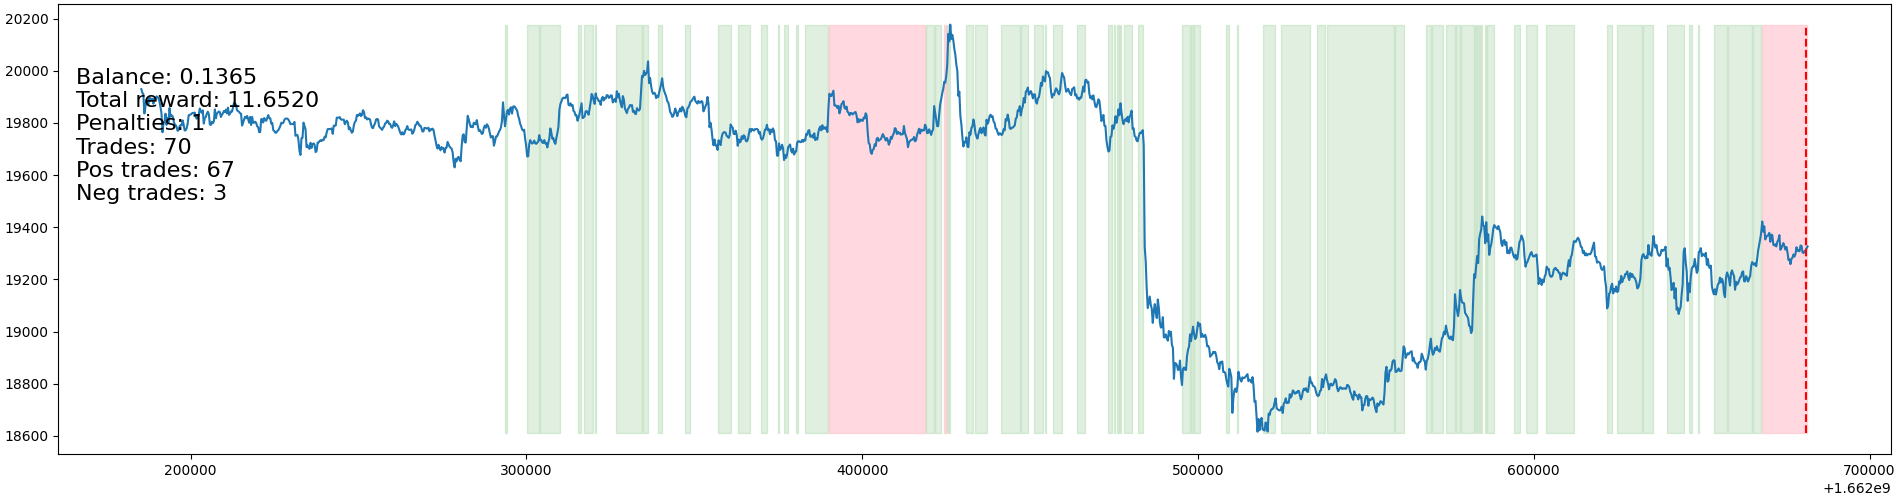

In [37]:
player = Player(env_core, model_test, dpf_train)
result = player.play(fig_size_x = 19, fig_size_y = 5, dpi = 50, font_size = 16)

<IPython.core.display.Javascript object>


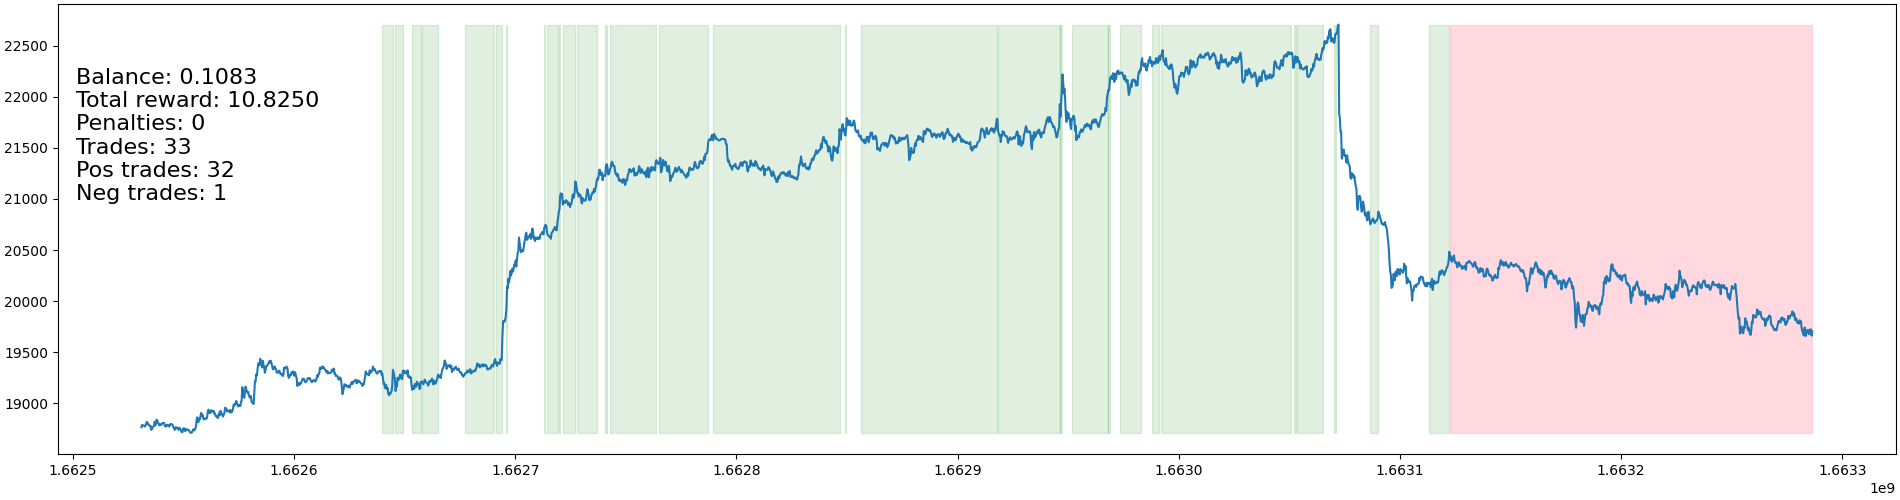

In [38]:
player = Player(env_core, model_test, dpf_test)
result = player.play(fig_size_x = 19, fig_size_y = 5, dpi = 50, font_size = 16)

# Сохранение модели и конфига

In [24]:
params = {
    "alias": ALIAS,
    "model_id": model_id,
    "core": core_config,
    "dataset": dataset_config,
    "observation": observation_config,
    "precompute": {"orderbook_levels": orderbook_levels},
    "trader": trader_config
}

tm.make_trade_config(params, model_id, suffix="top_model")

# Профилирование

In [32]:
profiler = cProfile.Profile()
max_frames = dpf_train.get_max_steps()

env_prof = TradeEnv(core_train, dpf_train, alias=ALIAS, log=False, log_obs=False)
model = create_q_model(env_prof)
model_target = create_q_model(env_prof)
agent = DQN(env_prof, model, model_target, dqn_conf)

profiler.enable()

agent.train(max_frames=max_frames, goal_reward=20000)

profiler.disable()

23:36:12 ( 37 sec) | reward:   nan at episode 1, frame count 1355, epsilon: 0.99, loss:0.65


In [ ]:
# - ncalls : Shows the number of calls made
# - tottime: Total time taken by the given function. 
# Note that the time made in calls to sub-functions are excluded.
# - percall: Total time / No of calls. ( remainder is left out )
# - cumtime: Unlike tottime, this includes time       spent in this and all subfunctions that the higher-level function calls. It is most useful and is accurate for recursive functions.
# The percall following cumtime is calculated as the quotient of cumtime divided by primitive calls. The primitive calls include all the calls that were not included through recursion.


stats = pstats.Stats(profiler).sort_stats('tottime')
stats.print_stats()

# Сохранение модели и конфига

In [ ]:
progress_keeper = ProgressKeeper(ALIAS, models_path="/Users/alex/Dev_projects/RT/rt_models")
progress_keeper.make_snapshot(agent, train_agent_wrapper.results)

# Визуализация весов модели (не завершено)

In [ ]:
model.layers[2]

In [ ]:
from matplotlib import pyplot as plt

filters, biases = model.layers[1].get_weights()

# normalize filter values to 0-1 so we can visualize them
#f_min, f_max = filters.min(), filters.max()
#filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
filters.shape

In [ ]:
filters, biases = model.layers[3].get_weights()


cols = 2 #filters.shape[0]
rows = filters.shape[1]

fix, ax = plt.subplots(figsize=(13,20), nrows=rows, ncols=cols)

for row_idx in range(rows):
    for col_idx in range(cols):
       
        ax[row_idx][col_idx].set_xticks([])
        ax[row_idx][col_idx].set_yticks([])
         
        ax[row_idx][col_idx].plot(filters[col_idx, row_idx, :])
  
